In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



<Logger detectron2 (DEBUG)>

In [2]:
import numpy as np
import cv2
import random


In [3]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

%matplotlib inline

from matplotlib import pyplot as plt

In [4]:
import json

def get_board_dicts(imgdir):
    json_file = imgdir+"/_annotations.coco.json" #Fetch the json file
    new_dict = []
    with open(json_file) as f:
        dataset_dicts = json.load(f)
    for i in range(len(dataset_dicts["images"])):
        entry = {}
        entry["image_id"] = int(dataset_dicts["images"][i]["id"])
        entry["file_name"] = imgdir+"/"+dataset_dicts["images"][i]["file_name"]
        entry["height"] = dataset_dicts["images"][i]["height"]
        entry["width"] = dataset_dicts["images"][i]["width"]
        
        annots = []
        
        for j in range(len(dataset_dicts["annotations"])):
            annot = {}
            if (entry["image_id"] == int(dataset_dicts["annotations"][j]["image_id"])):
                annot["bbox"] = dataset_dicts["annotations"][j]["bbox"]
                annot["bbox_mode"] = BoxMode.XYWH_ABS
                annot["category_id"] = int(dataset_dicts["annotations"][j]["category_id"])
                annots.append(annot)
        
        entry["annotations"] = annots
        
        new_dict.append(entry)

    return new_dict

from detectron2.data import DatasetCatalog, MetadataCatalog
#Registering the Dataset
for d in ["test","train", "valid"]:
    DatasetCatalog.register("boardetect_" + d, lambda d=d: get_board_dicts("DL_final_v3/" + d))
    MetadataCatalog.get("boardetect_" + d).set(thing_classes=["garbage","glass","metal","paper","plastic"])
board_metadata = MetadataCatalog.get("boardetect_train")

{'image_id': 357, 'file_name': 'DL_final_v3/test/plastic129_jpg.rf.ebc4eead3d2b62ce5645d812819e29d2.jpg', 'height': 250, 'width': 250, 'annotations': [{'bbox': [32, 117, 140.5, 103], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 4}]}


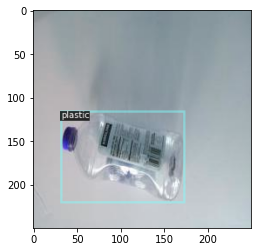

{'image_id': 76, 'file_name': 'DL_final_v3/test/glass140_jpg.rf.488b3f910129ceafc19361dcae106dd8.jpg', 'height': 250, 'width': 250, 'annotations': [{'bbox': [58, 70, 99.5, 95.5], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}]}


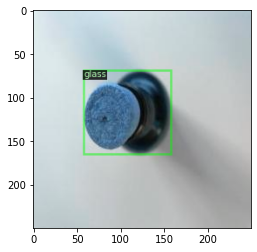

{'image_id': 215, 'file_name': 'DL_final_v3/test/glass392_jpg.rf.937ee4b217d97438dc3c4daaf3968d8c.jpg', 'height': 250, 'width': 250, 'annotations': [{'bbox': [69, 17, 142, 186], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}]}


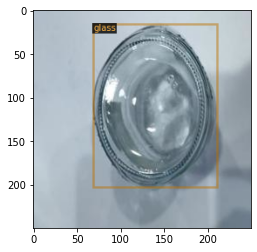

In [5]:
#Visualizing the Train Dataset
dataset_dicts = get_board_dicts("DL_final_v3/test")
#Randomly choosing 3 images from the Set
for d in random.sample(dataset_dicts, 3):
    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=board_metadata)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [6]:
board_metadata.get("thing_classes", None)

['garbage', 'glass', 'metal', 'paper', 'plastic']

In [9]:
model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

'https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl'

In [5]:
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultTrainer

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [6]:
from detectron2.config import get_cfg
import os

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
#cfg.MODEL.WEIGHTS = "model_final_68b088.pkl"
cfg.MODEL.WEIGHTS = "model_final_f6e8b1.pkl"

cfg.DATASETS.TRAIN = ("boardetect_train",)
cfg.DATASETS.TEST = ("boardetect_valid",)

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125

#cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2500 #adjust up if val mAP is still rising, adjust down if overfit
#cfg.SOLVER.STEPS = (1000, 1500)
#cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/25 10:35:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.


[12/25 10:35:37 d2.engine.train_loop]: Starting training from iteration 0
[12/25 10:35:48 d2.utils.events]:  eta: 0:21:31  iter: 19  total_loss: 1.522  loss_cls: 1.195  loss_box_reg: 0.249  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.5318  data_time: 0.0131  lr: 0.000250  max_mem: 4366M
[12/25 10:35:59 d2.utils.events]:  eta: 0:22:14  iter: 39  total_loss: 0.533  loss_cls: 0.258  loss_box_reg: 0.266  loss_rpn_cls: 0.001  loss_rpn_loc: 0.004  time: 0.5393  data_time: 0.0057  lr: 0.000500  max_mem: 4366M
[12/25 10:36:10 d2.utils.events]:  eta: 0:22:04  iter: 59  total_loss: 0.474  loss_cls: 0.185  loss_box_reg: 0.287  loss_rpn_cls: 0.001  loss_rpn_loc: 0.003  time: 0.5390  data_time: 0.0055  lr: 0.000749  max_mem: 4366M
[12/25 10:36:20 d2.utils.events]:  eta: 0:21:24  iter: 79  total_loss: 0.463  loss_cls: 0.171  loss_box_reg: 0.287  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.5374  data_time: 0.0056  lr: 0.000999  max_mem: 4366M
[12/25 10:36:31 d2.utils.events]:  eta: 0:21:2

In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

In [8]:
evaluator = COCOEvaluator("boardetect_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "boardetect_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [12/25 10:59:54 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'boardetect_test'. Trying to convert it to COCO format ...
[12/25 10:59:54 d2.data.datasets.coco]: Converting annotations of dataset 'boardetect_test' to COCO format ...)
[12/25 10:59:54 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/25 10:59:54 d2.data.datasets.coco]: Conversion finished, #images: 393, #annotations: 393
[12/25 10:59:54 d2.data.datasets.coco]: Caching COCO format annotations at './output/boardetect_test_coco_format.json' ...
[12/25 10:59:55 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  garbage   | 0            |   glass    | 145          |   metal    | 37           |
|   paper    | 53           |  plastic   | 158          |            |              |
| 

OrderedDict([('bbox',
              {'AP': 76.08751635803954,
               'AP50': 86.38102721066917,
               'AP75': 84.92412153207763,
               'APs': nan,
               'APm': 62.65008072807935,
               'APl': 76.80338290688293,
               'AP-garbage': nan,
               'AP-glass': 79.78703260218278,
               'AP-metal': 60.46774369179747,
               'AP-paper': 87.5466558784118,
               'AP-plastic': 76.5486332597661})])

In [14]:
%ls ./output/

boardetect_test_coco_format.json
boardetect_test_coco_format.json.lock
coco_instances_results.json
events.out.tfevents.1608689145.gpu0.davidson.edu.1154274.0
events.out.tfevents.1608689208.gpu0.davidson.edu.1154274.1
events.out.tfevents.1608689265.gpu0.davidson.edu.1154274.2
events.out.tfevents.1608689688.gpu0.davidson.edu.1154274.3
events.out.tfevents.1608690130.gpu0.davidson.edu.1154274.4
events.out.tfevents.1608729856.gpu0.davidson.edu.1220263.0
events.out.tfevents.1608730667.gpu0.davidson.edu.1220263.1
events.out.tfevents.1608732372.gpu0.davidson.edu.1220263.2
events.out.tfevents.1608732457.gpu0.davidson.edu.1220263.3
events.out.tfevents.1608733139.gpu0.davidson.edu.1220263.4
events.out.tfevents.1608736839.gpu0.davidson.edu.1220263.5
events.out.tfevents.1608736952.gpu0.davidson.edu.1231997.0
instances_predictions.pth
last_checkpoint
metrics.json
model_final.pth


In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("boardetect_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("boardetect_test")

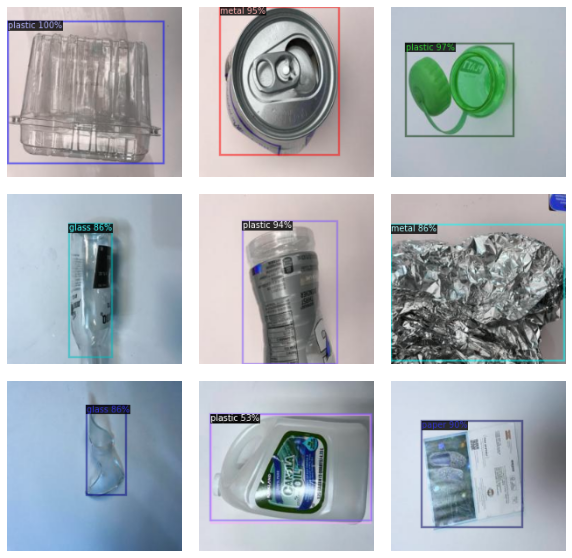

In [16]:
from detectron2.utils.visualizer import ColorMode
import glob

counter = 0
i = 0
images = [7,2,3,6,10,12,16,19,37]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))

for imageName in glob.glob('DL_final/test/*jpg'):
    if (counter in images):
        row = i // 3
        col = i % 3
        im = cv2.imread(imageName)
        outputs = predictor(im)
        v = Visualizer(im[:, :, ::-1],
                    metadata=test_metadata, 
                    scale=0.8
                     )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        axes[row, col].axis("off")
        axes[row, col].imshow(out.get_image()[:, :, ::-1], aspect="auto")
        i += 1
    counter += 1
    
plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()